Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Resolving data files:   0%|          | 0/40 [00:00<?, ?it/s]

Vanilla CLIP attention maps:


`torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to eager attention. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


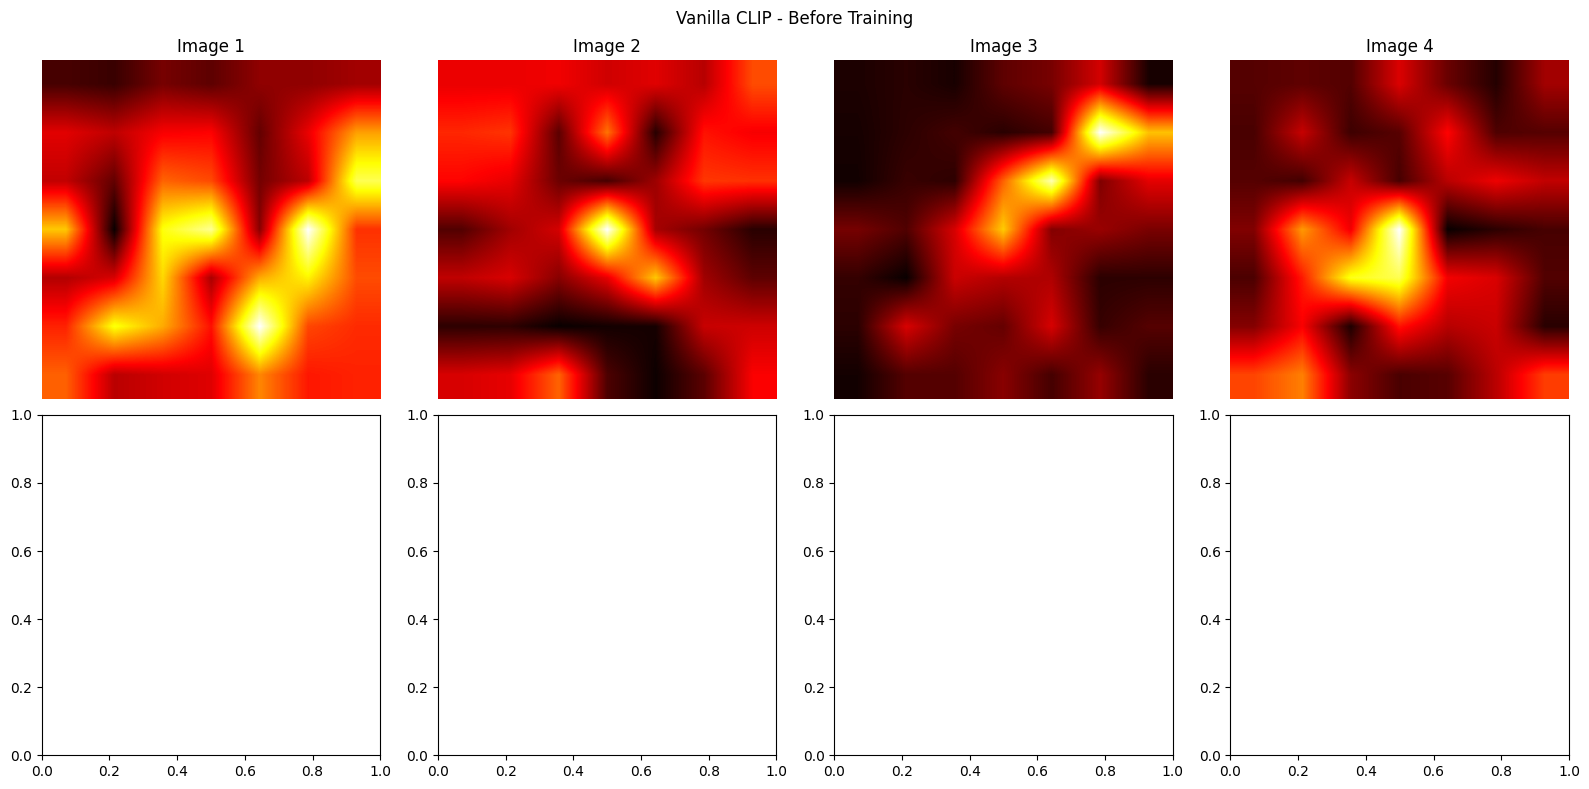

Vanilla CLIP region classification accuracy: 0.1111


Epoch 1/2: 100%|██████████| 250/250 [00:27<00:00,  9.21it/s, Loss=0.2425, Content=0.2024, Context=0.1606]


Epoch 1 - Avg Loss: 0.3851, Content: 0.3389, Context: 0.1848


Epoch 2/2: 100%|██████████| 250/250 [00:27<00:00,  9.24it/s, Loss=0.2111, Content=0.1677, Context=0.1734]


Epoch 2 - Avg Loss: 0.2415, Content: 0.1984, Context: 0.1725
DeCLIP attention maps after training:


IndexError: too many indices for tensor of dimension 1

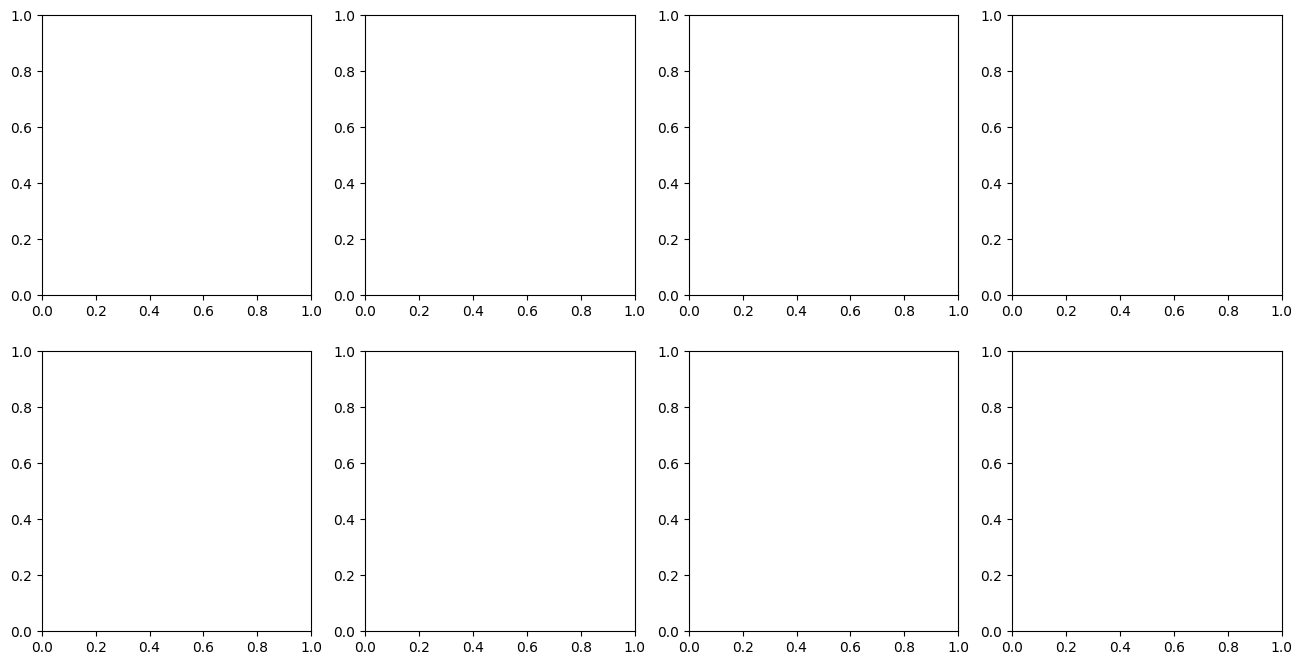

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import CLIPModel, CLIPProcessor
from transformers.models.clip.modeling_clip import CLIPEncoderLayer
import timm
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class DeCLIPDataset(Dataset):
    def __init__(self, num_samples=1000, processor=None):
        self.dataset = list(load_dataset("detection-datasets/coco", split="val", streaming=True).take(num_samples))
        self.processor = processor
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        crops, coords = self.generate_grid_crops(image)
        
        processed_image = self.processor(images=image, return_tensors="pt")
        processed_crops = [self.processor(images=crop, return_tensors="pt") for crop in crops]
        
        return {
            'pixel_values': processed_image['pixel_values'].squeeze(0),
            'crop_pixel_values': torch.stack([c['pixel_values'].squeeze(0) for c in processed_crops]),
            'crop_coords': torch.tensor(coords, dtype=torch.float32)
        }
    
    def generate_grid_crops(self, image, grid_size=3):
        w, h = image.size
        crop_w, crop_h = w // grid_size, h // grid_size
        
        crops = []
        coords = []
        
        for i in range(grid_size):
            for j in range(grid_size):
                x1 = j * crop_w
                y1 = i * crop_h
                x2 = min(x1 + crop_w, w)
                y2 = min(y1 + crop_h, h)
                
                crop = image.crop((x1, y1, x2, y2))
                crops.append(crop)
                coords.append([x1/w, y1/h, x2/w, y2/h])
                
        return crops, coords

class DecoupledCLIPEncoderLayer(nn.Module):
    def __init__(self, original_layer):
        super().__init__()
        self.self_attn = original_layer.self_attn
        self.layer_norm1 = original_layer.layer_norm1
        self.mlp = original_layer.mlp
        self.layer_norm2 = original_layer.layer_norm2
        
        config = original_layer.self_attn.config
        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.head_dim = self.embed_dim // self.num_heads
        
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)
        
        with torch.no_grad():
            self.q_proj.weight.copy_(self.self_attn.q_proj.weight)
            self.q_proj.bias.copy_(self.self_attn.q_proj.bias)
            self.v_proj.weight.copy_(self.self_attn.v_proj.weight)
            self.v_proj.bias.copy_(self.self_attn.v_proj.bias)
            self.out_proj.weight.copy_(self.self_attn.out_proj.weight)
            self.out_proj.bias.copy_(self.self_attn.out_proj.bias)
    
    def forward(self, hidden_states, attention_mask=None, causal_attention_mask=None, output_attentions=False):
        residual = hidden_states
        hidden_states = self.layer_norm1(hidden_states)
        
        batch_size, seq_len, _ = hidden_states.size()
        
        context_features = self.q_proj(hidden_states)
        value_features = self.v_proj(hidden_states)
        
        context_features = context_features.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        value_features = value_features.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        attention_weights = torch.matmul(context_features, context_features.transpose(-1, -2)) / np.sqrt(self.head_dim)
        attention_probs = F.softmax(attention_weights, dim=-1)
        
        content_features = torch.matmul(attention_probs, value_features)
        content_features = content_features.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)
        content_features = self.out_proj(content_features)
        
        hidden_states = residual + content_features
        residual = hidden_states
        hidden_states = self.layer_norm2(hidden_states)
        hidden_states = self.mlp(hidden_states)
        hidden_states = residual + hidden_states
        
        outputs = (hidden_states,)
        if output_attentions:
            outputs += (attention_probs.mean(dim=1),)
        
        return outputs

class DeCLIPModel(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.clip = clip_model
        self.original_last_layer = self.clip.vision_model.encoder.layers[-1]
        self.clip.vision_model.encoder.layers[-1] = DecoupledCLIPEncoderLayer(self.original_last_layer)
        
        for param in self.clip.parameters():
            param.requires_grad = False
            
        for param in self.clip.vision_model.encoder.layers[-1].parameters():
            param.requires_grad = True
    
    def forward(self, pixel_values, output_attentions=False):
        outputs = self.clip.vision_model(pixel_values=pixel_values, output_attentions=output_attentions)
        return outputs
    
    def get_image_features(self, pixel_values):
        outputs = self.forward(pixel_values)
        return self.clip.visual_projection(outputs[1])

def roi_pool(features, coords, output_size=1):
    batch_size, num_crops = coords.shape[0], coords.shape[1]
    pooled_features = []
    
    for b in range(batch_size):
        for c in range(num_crops):
            x1, y1, x2, y2 = coords[b, c]
            h_start = int(y1 * 7)
            h_end = int(y2 * 7)
            w_start = int(x1 * 7)
            w_end = int(x2 * 7)
            
            h_start = max(0, min(h_start, 6))
            h_end = max(h_start + 1, min(h_end, 7))
            w_start = max(0, min(w_start, 6))
            w_end = max(w_start + 1, min(w_end, 7))
            
            region_features = features[b, :, h_start:h_end, w_start:w_end]
            pooled = F.adaptive_avg_pool2d(region_features.unsqueeze(0), output_size)
            pooled_features.append(pooled.squeeze(0))
    
    return torch.stack(pooled_features).view(batch_size, num_crops, -1)

def compute_content_loss(student_model, teacher_model, images, crops, coords):
    with torch.no_grad():
        teacher_outputs = []
        for b in range(crops.shape[0]):
            crop_features = teacher_model.get_image_features(crops[b])
            teacher_outputs.append(crop_features)
        teacher_features = torch.stack(teacher_outputs)
    
    student_outputs = student_model(images)
    student_hidden = student_outputs.last_hidden_state
    
    B, L, D = student_hidden.shape
    H = W = int(np.sqrt(L - 1))
    student_spatial = student_hidden[:, 1:, :].transpose(1, 2).view(B, D, H, W)
    
    student_spatial_normalized = F.normalize(student_model.clip.visual_projection(student_spatial.view(B, D, -1).transpose(1, 2)), dim=-1)
    student_spatial_normalized = student_spatial_normalized.transpose(1, 2).view(B, -1, H, W)
    
    student_regions = roi_pool(student_spatial_normalized, coords)
    
    teacher_features_norm = F.normalize(teacher_features, dim=-1)
    student_regions_norm = F.normalize(student_regions, dim=-1)
    
    similarity = F.cosine_similarity(student_regions_norm, teacher_features_norm, dim=-1)
    loss = 1 - similarity.mean()
    
    return loss

def compute_context_loss(student_outputs, teacher_model, images):
    student_hidden = student_outputs.last_hidden_state[:, 1:, :]
    
    with torch.no_grad():
        teacher_features = teacher_model.forward_features(images)
        if teacher_features.dim() == 3:
            teacher_hidden = teacher_features[:, 1:, :]
        else:
            teacher_hidden = teacher_features
            
    min_len = min(student_hidden.size(1), teacher_hidden.size(1))
    student_hidden = student_hidden[:, :min_len, :]
    teacher_hidden = teacher_hidden[:, :min_len, :]
    
    student_corr = F.cosine_similarity(student_hidden.unsqueeze(1), student_hidden.unsqueeze(2), dim=-1)
    teacher_corr = F.cosine_similarity(teacher_hidden.unsqueeze(1), teacher_hidden.unsqueeze(2), dim=-1)
    
    context_loss = F.mse_loss(student_corr, teacher_corr)
    
    return context_loss

def visualize_attention_maps(model, images, title="Attention Maps"):
    model.eval()
    with torch.no_grad():
        outputs = model(images, output_attentions=True)
        attentions = outputs.attentions[-1]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i in range(min(8, images.shape[0])):
        attn = attentions[i].mean(dim=0)
        
        token_idx = 25
        attn_map = attn[token_idx, 1:].reshape(7, 7)
        
        axes[i].imshow(attn_map.cpu().numpy(), cmap='hot', interpolation='bilinear')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def evaluate_region_classification(model, clip_full_model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in dataloader:
            images = batch['pixel_values'].to(device)
            crops = batch['crop_pixel_values'].to(device)
            coords = batch['crop_coords'].to(device)
            
            for b in range(images.shape[0]):
                student_outputs = model(images[b:b+1])
                student_hidden = student_outputs.last_hidden_state
                
                B, L, D = student_hidden.shape
                H = W = int(np.sqrt(L - 1))
                student_spatial = student_hidden[:, 1:, :].transpose(1, 2).view(B, D, H, W)
                
                if hasattr(model, 'clip'):
                    visual_projection = model.clip.visual_projection
                else:
                    visual_projection = clip_full_model.visual_projection
                
                student_spatial_normalized = F.normalize(
                    visual_projection(student_spatial.view(B, D, -1).transpose(1, 2)), 
                    dim=-1
                ).transpose(1, 2).view(B, -1, H, W)
                
                student_regions = roi_pool(student_spatial_normalized, coords[b:b+1])
                
                crop_features = clip_full_model.get_image_features(crops[b])
                
                similarities = F.cosine_similarity(
                    student_regions.squeeze(0), 
                    F.normalize(crop_features, dim=-1), 
                    dim=-1
                )
                
                predictions = similarities.argmax(dim=0)
                correct += (predictions == torch.arange(9).to(device)).sum().item()
                total += 9
    
    return correct / total

def train_declip():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    teacher_clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    teacher_clip.eval()
    
    teacher_dino = timm.create_model('vit_small_patch16_224.dino', pretrained=True, num_classes=0).to(device)
    teacher_dino.eval()
    
    declip_model = DeCLIPModel(clip_model).to(device)
    
    dataset = DeCLIPDataset(num_samples=1000, processor=processor)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)
    
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, declip_model.parameters()),
        lr=1e-5,
        weight_decay=0.1
    )
    
    test_batch = next(iter(dataloader))
    test_images = test_batch['pixel_values'][:8].to(device)
    
    print("Vanilla CLIP attention maps:")
    vanilla_clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    visualize_attention_maps(vanilla_clip.vision_model, test_images, "Vanilla CLIP - Before Training")
    
    vanilla_acc = evaluate_region_classification(vanilla_clip.vision_model, vanilla_clip, DataLoader(dataset, batch_size=8), device)
    print(f"Vanilla CLIP region classification accuracy: {vanilla_acc:.4f}")
    
    num_epochs = 2
    lambda_context = 0.25
    
    for epoch in range(num_epochs):
        declip_model.train()
        total_loss = 0
        content_losses = []
        context_losses = []
        
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch in progress_bar:
            images = batch['pixel_values'].to(device)
            crops = batch['crop_pixel_values'].to(device)
            coords = batch['crop_coords'].to(device)
            
            optimizer.zero_grad()
            
            student_outputs = declip_model(images, output_attentions=True)
            
            content_loss = compute_content_loss(declip_model, teacher_clip, images, crops, coords)
            context_loss = compute_context_loss(student_outputs, teacher_dino, images)
            
            loss = content_loss + lambda_context * context_loss
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            content_losses.append(content_loss.item())
            context_losses.append(context_loss.item())
            
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Content': f'{content_loss.item():.4f}',
                'Context': f'{context_loss.item():.4f}'
            })
        
        avg_loss = total_loss / len(dataloader)
        avg_content = np.mean(content_losses)
        avg_context = np.mean(context_losses)
        
        print(f"Epoch {epoch+1} - Avg Loss: {avg_loss:.4f}, Content: {avg_content:.4f}, Context: {avg_context:.4f}")
    
    print("DeCLIP attention maps after training:")
    visualize_attention_maps(declip_model, test_images, "DeCLIP - After Training")
    
    declip_acc = evaluate_region_classification(declip_model, declip_model.clip, DataLoader(dataset, batch_size=8), device)
    print(f"DeCLIP region classification accuracy: {declip_acc:.4f}")
    print(f"Improvement: {(declip_acc - vanilla_acc) * 100:.2f}%")
    
    return declip_model, vanilla_clip


declip_model, vanilla_clip = train_declip()